- Detailed EDA on
    - https://github.com/instork/EDA-exercise/blob/main/notebooks/data_validation__check_stats.ipynb

In [1]:
import os
import datetime as dt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


from numpy.linalg import LinAlgError

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima


In [2]:
hourly_btc_df = pd.read_csv('../../data/btc_df.csv', 
                           parse_dates=["utc_time"])


In [3]:
hourly_btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22550 entries, 0 to 22549
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   market                   22550 non-null  object        
 1   candle_date_time_utc     22550 non-null  object        
 2   candle_date_time_kst     22550 non-null  object        
 3   opening_price            22550 non-null  float64       
 4   high_price               22550 non-null  float64       
 5   low_price                22550 non-null  float64       
 6   trade_price              22550 non-null  float64       
 7   timestamp                22550 non-null  int64         
 8   candle_acc_trade_price   22550 non-null  float64       
 9   candle_acc_trade_volume  22550 non-null  float64       
 10  unit                     22550 non-null  int64         
 11  utc_time                 22550 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)

In [4]:
hourly_btc_df = hourly_btc_df.sort_values('utc_time')

In [5]:

def make_etz_time(df: pd.DataFrame, utc_col:str='utc_time', new_col:str='etz_time', time_diff = -5):
    df[new_col] = df[utc_col] + dt.timedelta(hours=time_diff)
    return df


hourly_btc_df = make_etz_time(hourly_btc_df)

hourly_btc_df['etz_date'] = hourly_btc_df['etz_time'].apply(lambda x: x.date())
conditions = {
            "etz_time": "first",
            "opening_price": "first",
            "high_price": "max", 
            "low_price": "min",  
            "trade_price": "last",
            "candle_acc_trade_price": "sum",
            "candle_acc_trade_volume": "sum"
    }


daily_btc_df = hourly_btc_df.groupby('etz_date').agg(conditions)
daily_btc_df = daily_btc_df.reset_index()
drop_fisrt = True # 


if daily_btc_df.etz_time.iloc[0].hour != 0 and drop_fisrt:
    daily_btc_df = daily_btc_df.iloc[1:]

    
hourly_btc_df = hourly_btc_df.set_index('etz_time')
daily_btc_df = daily_btc_df.set_index('etz_date')


hourly_btc_df.index = pd.to_datetime(hourly_btc_df.index)
daily_btc_df.index = pd.to_datetime(daily_btc_df.index)


In [6]:
houly_btc_series = np.log(hourly_btc_df.trade_price).diff()
daily_btc_series = np.log(daily_btc_df.trade_price).diff()

In [7]:
daily_btc_series = daily_btc_series.iloc[1:]

/home/nys/anaconda3/envs/forecasting-models/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


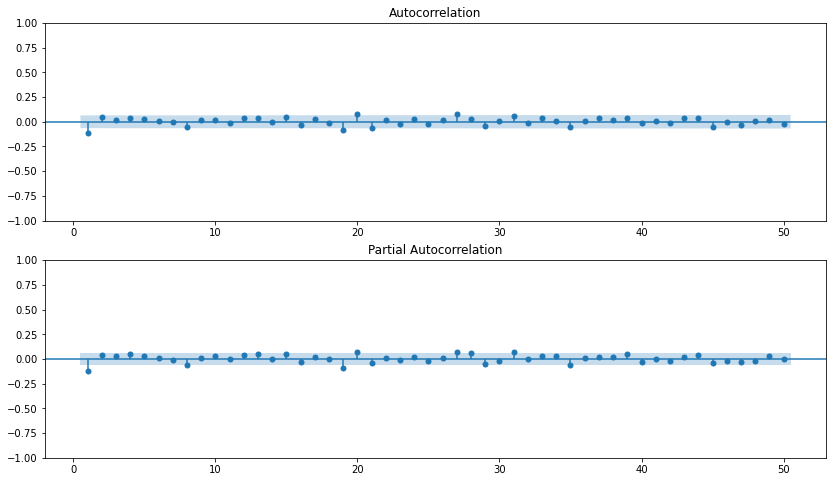

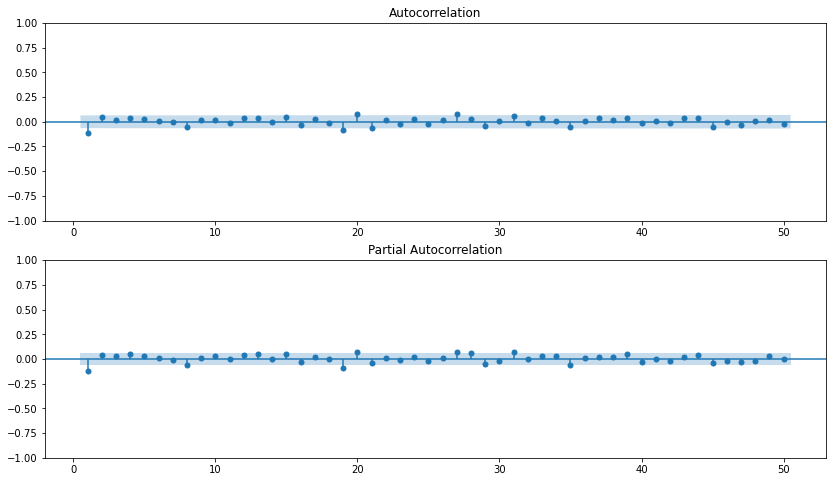

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

plot_acf(daily_btc_series, lags=50, zero=False, ax=axes[0])
plot_pacf(daily_btc_series, lags=50, zero=False, ax=axes[1])

## 검증데이터 샘플링

- 간단하게 1주 동안 
    - 상승장: 8% 상승
    - 횡보장: 1% 이내의 변화
    - 하락장: -8% 하락


In [9]:
one_week_log_diff = np.log(daily_btc_df.trade_price).diff(7)
one_week_log_diff = one_week_log_diff.dropna()
display(one_week_log_diff.describe())

# 검증데이터 끝 날짜
uptrend_dates = one_week_log_diff[one_week_log_diff > 0.1].index
sideway_dates = one_week_log_diff[(one_week_log_diff < 0.01) & (one_week_log_diff > -0.01)].index
downtrend_dates = one_week_log_diff[(one_week_log_diff < -0.1)].index

uptrend_dates = uptrend_dates[uptrend_dates > dt.datetime(2020,5,15)]
sideway_dates = sideway_dates[sideway_dates > dt.datetime(2020,5,15)]
downtrend_dates = downtrend_dates[downtrend_dates > dt.datetime(2020,5,15)]



count    933.000000
mean       0.007931
std        0.106470
min       -0.568347
25%       -0.040340
50%        0.009050
75%        0.064966
max        0.341528
Name: trade_price, dtype: float64

In [10]:
consider_dates = pd.date_range('2020-06-01', '2022-07-28', freq='7d')

uptrend_dates = [date for date in uptrend_dates if date in consider_dates]
sideway_dates = [date for date in sideway_dates if date in consider_dates]
downtrend_dates = [date for date in downtrend_dates if date in consider_dates]

print(len(uptrend_dates))
print(len(sideway_dates))
print(len(downtrend_dates))

20
16
17


In [11]:
df_2022 = daily_btc_df[daily_btc_df.index > dt.datetime(2022,1,1)]
uptrend_dates_2022 = [date for date in uptrend_dates if date > dt.datetime(2022,1,1) ]
sideway_dates_2022 = [date for date in sideway_dates if date > dt.datetime(2022,1,1) ]
downtrend_dates_2022 = [date for date in downtrend_dates if date > dt.datetime(2022,1,1) ]


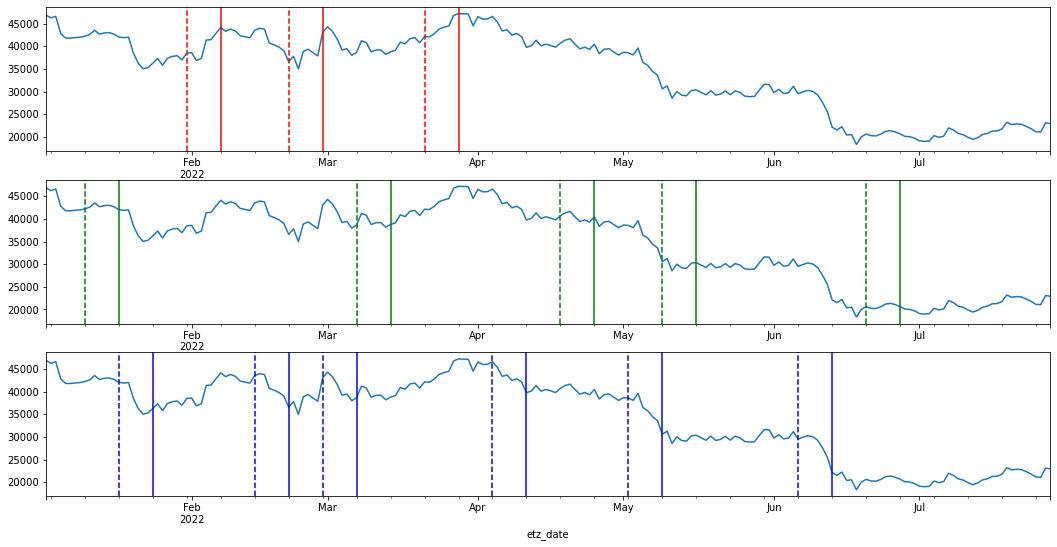

In [12]:

series_list = [df_2022.trade_price]*3

trend_list = [uptrend_dates_2022, sideway_dates_2022, downtrend_dates_2022]
colors = ['red', 'green', 'blue']

nrow = 3
ncol = 1
fig = plt.figure(figsize=(18, 9))
count = 0


def draw_vertical_line(ax, dates, color):
    for date in dates:
        start_date = (date-dt.timedelta(days=7)).strftime('%Y-%m-%d')
        end_date = date.strftime('%Y-%m-%d')
        ax.axvline(f"{start_date}", color=color, linestyle="dashed")
        ax.axvline(f"{end_date}", color=color, )

for r in range(nrow):
    for c in range(ncol):
        ax = fig.add_subplot(nrow, ncol, count+1 )
        series_list[count].plot()
        draw_vertical_line(ax, trend_list[count], colors[count])
        count+=1
        
        

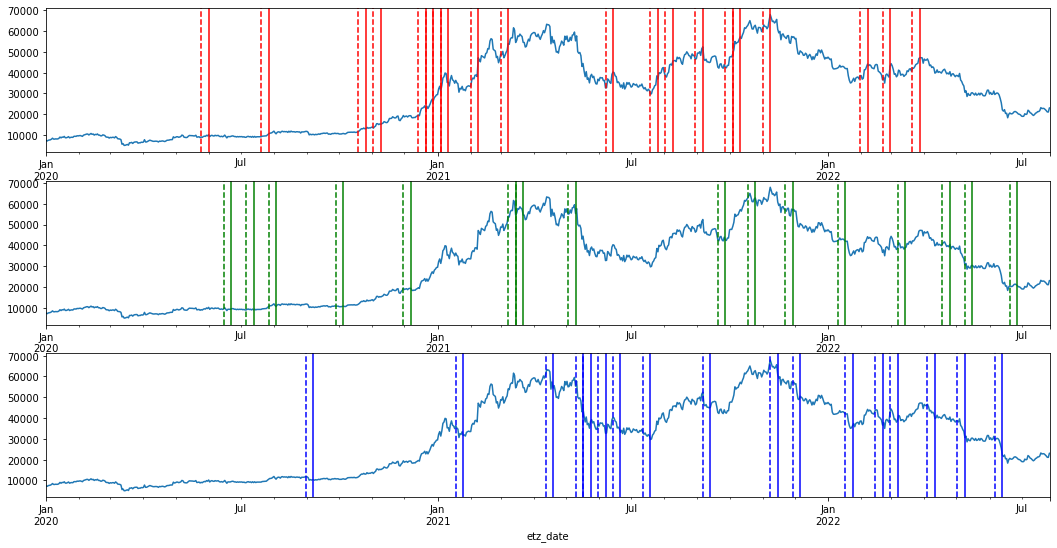

In [13]:

series_list = [daily_btc_df.trade_price]*3

trend_list = [uptrend_dates, sideway_dates, downtrend_dates]
colors = ['red', 'green', 'blue']

nrow = 3
ncol = 1
fig = plt.figure(figsize=(18, 9))
count = 0


def draw_vertical_line(ax, dates, color):
    for date in dates:
        start_date = (date-dt.timedelta(days=7)).strftime('%Y-%m-%d')
        end_date = date.strftime('%Y-%m-%d')
        ax.axvline(f"{start_date}", color=color, linestyle="dashed")
        ax.axvline(f"{end_date}", color=color, )

for r in range(nrow):
    for c in range(ncol):
        ax = fig.add_subplot(nrow, ncol, count+1 )
        series_list[count].plot()
        draw_vertical_line(ax, trend_list[count], colors[count])
        count+=1
        
        


- Training size 
    - 30, 60, 90, 120 days
- validation size
    
- context: 
    - training context: 어떻게 정의하지? 상승장과 하락장을
    - validataion context






- d는 이미 1임 (로그차분 수행)

In [14]:
from itertools import product
train_sizes = [30, 60, 90, 120, 180]
p_range = [1,2,3]
d_range = [0,1]
q_range = [0,1,2]

params = list(product(p_range, d_range, q_range))

len(params) * len(train_sizes)

90

In [15]:
q, d, q = params[2]


In [16]:
val_uptrend_dates = [(d-dt.timedelta(days=6), "uptrend") for d in uptrend_dates]
val_sideway_dates = [(d-dt.timedelta(days=6), "sideway") for d in sideway_dates]
val_downtrend_dates = [(d-dt.timedelta(days=6), "downtrend") for d in downtrend_dates]

In [17]:
val_start_dates = val_uptrend_dates + val_sideway_dates + val_downtrend_dates

In [18]:
def get_train_val_sets(full_set, start_date, train_size):
    start_dates = pd.date_range(start_date, start_date+dt.timedelta(days=6), freq='1d')
    train_sets = []
    for start_date in start_dates:
        train_idx = pd.date_range(start_date-dt.timedelta(days=train_size), 
                                  start_date-dt.timedelta(days=1), freq='1d')
        train_sets.append(full_set[full_set.index.isin(train_idx)])
    val_sets = full_set[full_set.index.isin(start_dates)]
    return train_sets, val_sets

In [19]:
import warnings
import gc
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

In [20]:
file_dir = '../../data/arima'
os.makedirs(file_dir, exist_ok=True)

In [21]:

train_sizes = [1,2,3,4,5,6,7] 
p_range = [0,1] 
d_range = [0,1,2,3,4,5,6,7] 
q_range = [28, 30, 60, 90, 120, 180]

len(train_sizes)* len(p_range)* len(d_range)* len(q_range)

672

- p, d가 커질 수록 학습 속도가 많이 느려짐
- NNI 실험으로 변경

## 실험 1, 2 

In [22]:
## NNI 실험으로 변경


# for p,d,q in tqdm(params):
#     if p == 0 and q == 0:
#         continue
#     for train_size in train_sizes:
#         full_results = []
#         for val_start_date in val_start_dates:
#             start_date, val_type = val_start_date
#             convergence_error, stationarity_error = 0, 0
#             val_preds_steps = []
#             val_preds_seq = None
#             aic = []
#             bic = []
#             train_sets, val_sets = get_train_val_sets(daily_btc_series, start_date, train_size)
#             for i, train_set in enumerate(train_sets):
#                 try:
#                     model = ARIMA(endog=train_set, order=(p, d, q)).fit(low_memory=True)
#                 except LinAlgError:
#                     convergence_error += 1
#                 except ValueError:
#                     stationarity_error += 1
#                 forecast = model.forecast(steps=1)
#                 val_preds_steps.append(forecast)

#                 aic.append(model.aic)
#                 bic.append(model.bic)
#                 if i == 0:
#                     val_preds_seq = model.forecast(steps=7)
#                 # del model; gc.collect()

#             val_preds_steps = pd.concat(val_preds_steps)
#             val_preds_steps = val_preds_steps.values
#             val_preds_seq = val_preds_seq.values
#             val_true = val_sets.values

#             rmse_seq = np.sqrt(mean_squared_error(y_true=val_true, y_pred=val_preds_seq))
#             rmse_steps = np.sqrt(mean_squared_error(y_true=val_true, y_pred=val_preds_steps))

#             cur_results = dict(
#                         start_date = start_date,
#                         val_type = val_type,
#                         rmse_seq = rmse_seq,
#                         rmse_steps = rmse_steps,
#                         aic = np.mean(aic),
#                         bic = np.mean(bic),
#                         convergence_error = convergence_error,
#                         stationarity_error = stationarity_error,
#             )
#             full_results.append(cur_results)
#             # del cur_results; gc.collect()

#         file_name = f'{p}_{d}_{q}_{train_size}.csv'
#         file_loc = os.path.join(file_dir, file_name)
#         full_results_df = pd.DataFrame(full_results)
#         full_results_df.to_csv(file_loc, index=False)
#         # del full_results_df; gc.collect()


In [23]:

daily_btc_df = pd.DataFrame(daily_btc_series)
daily_btc_df = daily_btc_df.reset_index()

val_start_trend = pd.DataFrame(val_start_dates)
val_start_trend.columns = ['etz_date', 'trend']

# daily_btc_df.to_csv('../../data/daily_btc_df.csv', index=False)
# val_start_trend.to_csv('../../data/val_start_trend.csv', index=False)

In [24]:
# NNI Exp
# nnictl create --config models/time-series/arima-config.yml            

## 실험 3

In [25]:
# daily_btc_df = pd.read_csv('../../data/daily_btc_df.csv', parse_dates=['etz_date'])
# daily_btc_df = daily_btc_df.set_index('etz_date')
# daily_btc_series = daily_btc_df.trade_price

# p, d, q = 1,0,1

# max_train_size = 180
# train_size = 60

# val_full_set = daily_btc_series.iloc[max_train_size:]


# val_preds_steps = []
# convergence_error, stationarity_error = 0, 0

# aic = []
# bic = []

# for i in range(len(val_full_set)):
#     train_set = daily_btc_series.iloc[i:max_train_size+i].iloc[-train_size:]
#     try:
#         model = ARIMA(endog=train_set, order=(p, d, q)).fit()
#         forecast = model.forecast(steps=1)
#         cur_aic = model.aic
#         cur_bic = model.bic

#     except LinAlgError:
#         new_idx = val_preds_steps[-1].index[0] + dt.timedelta(days=1)
#         forecast = pd.Series(np.nan, index=[new_idx])
#         cur_aic = np.nan
#         cur_bic = np.nan
#         convergence_error += 1
#         logger.info(f"LinAlgError {convergence_error} {new_idx}")

#     except ValueError:
#         new_idx = val_preds_steps[-1].index[0] + dt.timedelta(days=1)
#         forecast = pd.Series(np.nan, index=[new_idx])
#         cur_aic = np.nan
#         cur_bic = np.nan
#         stationarity_error += 1
#         logger.info(f"stationarity_error {stationarity_error} {new_idx}")

#     val_preds_steps.append(forecast)

#     aic.append(cur_aic)
#     bic.append(cur_bic)

#     if i % 10 == 0:
#         y_pred = pd.concat(val_preds_steps).values
#         y_true = val_full_set.iloc[:i+1].values
#         # print(y_true, y_pred)
#         # print(np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)))
#         # nni.report_intermediate_result(rmse_steps)

# assert len(val_full_set) == len(val_preds_steps) == len(aic) == len(bic)

# val_preds_steps = pd.concat(val_preds_steps)
# result_df = pd.concat([val_full_set, val_preds_steps], axis=1)
# result_df.columns = ["y_true", "y_pred"]
# result_df["aic"] = aic
# result_df["bic"] = bic

# rmse = np.sqrt(mean_squared_error(y_true=result_df.y_true, y_pred=result_df.y_pred))

## 실험 4

- update가 가능하지만, 한 모델로 쭉가는 것이기 때문에 계속 auto_arima하는 걸로

In [26]:
# daily_btc_df = pd.DataFrame(daily_btc_series)
# daily_btc_df = daily_btc_df.reset_index()

# val_start_trend = pd.DataFrame(val_start_dates)
# val_start_trend.columns = ['etz_date', 'trend']

In [27]:
# from pmdarima.arima import auto_arima

In [52]:
# train_size = 120

# max_train_size = 180

# #if do_update = False:

# val_full_set = daily_btc_series.iloc[max_train_size:].iloc[:30]
# i = 0

# aic = []
# bic = []
# val_preds_steps = []
# orders = []

# for i in range(len(val_full_set)):
    
#     train_set = daily_btc_series.iloc[i:max_train_size+i].iloc[-train_size:]
#     model = auto_arima(y=train_set, start_p=1, start_q=1, start_P=1, start_Q=1,
#                          max_p=5, max_q=5, max_P=5, max_Q=5,stepwise=True,seasonal=True,
#                        trace=False)

#     forcast = model.predict(n_periods=1)
#     model_summary = model.to_dict()
#     cur_order = model_summary['order']
#     cur_aic = model_summary['aic']
#     cur_bic = model_summary['bic']

#     val_preds_steps.append(forcast[0]) 
#     orders.append(cur_order)    
#     aic.append(cur_aic)
#     bic.append(cur_bic)
#     if i % 10 == 0 and i > 0:
#         y_pred = val_preds_steps
#         y_true = val_full_set.iloc[:i+1].values
#         print(len(y_pred))
#         print(len(y_true))
#         print(np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)))
        
# y_true = val_full_set.iloc[:i+1].values        
# y_pred = val_preds_steps
# rmse = np.sqrt(mean_squared_error(y_pred=val_preds_steps, y_true=y_true))
# result_df = pd.DataFrame(val_full_set)
# result_df.columns = ['y_true']
# result_df['y_pred'] = val_preds_steps
# result_df['aic'] = aic
# result_df['bic'] = bic
# result_df[['p','d','q']] = orders 

# rmse = np.sqrt(mean_squared_error(y_true=result_df.y_true, y_pred=result_df.y_pred))



## References

- https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/09_time_series_models/02_arima_models.ipynb
- https://alkaline-ml.com/pmdarima/auto_examples/index.html
